In [1]:
#!pip install pandas
#!pip install scipy
#!pip install scikit-learn
#!pip install imbalanced-learn 
#!pip install matplotlib
#!pip install xgboost
#!pip install tensorflow

     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ---------------------------------------- 61.2/61.2 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/341.8 kB ? eta -:--:--
     ------------------------------------- 341.8/341.8 kB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/10.6 MB 26.8 MB/s eta 0:00:01
   --------- ------------------------------ 2.5/10.6 MB 26.8 MB/s eta 0:00:01
   ------------- -------------------------- 3.5/10.6 MB 28.1 MB/s eta 0:00:01
   ------------------ --------------------- 4.9/10.6 MB 28.6 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/10.6 MB 27.8 MB/s eta 0:00:01
   ------------------- -------------------- 5.2/10.6 MB 27.8 MB/s eta 0:00:01
   ------------------------ --------------- 6.6/10.6 MB 21.2 MB/s eta 0:00:01
   ----------------------------- ---------- 7.9/10.6 MB 21.1 MB/s eta 0:00:01
 

# <ins> Modelling Overview:</ins> 

  Since the test data set does not provide the Numosquitos feature, this section will begin with the prediction of Numosquitos first. After that, the Numosquitos features will   be engineered into the test data set to predict the presence of WNV.

  3 models were used to predict the number of mosquitos. They are the neural network, random forest regressor, and XGboost regressor.
  
  These predictions were saved as separate test data frames, and each of the data frames was fitted to the below-listed models to predict the presence of WNV. 

  1. Random Forest Classifier 

  2. Support Vector Classifier 

  3. Logistic Regression

  3. XGBoost Classifier 

  4. Neural Network

  The model's results are summarised and analyzed at the end of this notebook.

## Importing Libraries and Data Preprocessing for Modelling 

In [1]:
import sys
sys.path.append('./py files/')

In [122]:
#importing general liabraries
import pandas as pd
import numpy as np

#from data_cleaner import DataCleaner
from data_cleaner_with_test_df_functionality import DataCleaner



from imblearn.combine import SMOTETomek


import matplotlib.pyplot as plt

from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, classification_report, RocCurveDisplay, roc_auc_score

from xgboost import XGBClassifier ,XGBRegressor

#tensorflow packages for neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Loading Data Frames

In [168]:
train_df = pd.read_csv("./train_sprayed_month_engineered.csv")
test_df = pd.read_csv("./test_final (2).csv")
test_df_nm = pd.read_csv("./testnm_nn.csv")
test_df_nm_rf = pd.read_csv("./testnm_rfr.csv")
test_df_nm_xgc = pd.read_csv("./test_xgrnm.csv")# load heree

## <ins>Predicting Num Mosquitos</ins> 

In [5]:
#Cleaning data to predict nummosquitos
features_predNM = ['Species', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month']
clean_predNM = DataCleaner(train_df, features_predNM, test_df, mode = 'num_mosquitos')
clean_predNM.clean()
clean_predNM.clean_test()
clean_predNM.test_df['PrecipTotal'] = clean_predNM.test_df['PrecipTotal'].fillna(0)

NOTICE: num_mosquitos mode has been selected. In this mode, the DataCleaner object is only intended to work with the training dataset, and only for the purposes of training a model to impute values into the NumMosquitos column of the test dataset. Once that test dataset containing the NumMosquitos column has been imputed, reinstatiate a new DataCleaner object in 'wnv' mode with the test dataset passed in as an argument.


In [6]:
#upsampling the data
smt = SMOTETomek(random_state=42)

Xnm_res, ynm_res = smt.fit_resample(clean_predNM.X_train, clean_predNM.y_train)

### Neural Network for Num Mosquitos

In [7]:
# Creating model using the Sequential in tensorfloow 
model_nm = Sequential([
    Dense(160, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(480, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])

In [8]:
#compliling model
msle = MeanSquaredLogarithmicError()
model_nm.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=0.0001), 
    metrics=[msle]
)
# train the model
history = model_nm.fit(
    Xnm_res.values, 
    ynm_res.values,
    validation_data = (clean_predNM.X_test, clean_predNM.y_test),
    epochs=500, 
    batch_size=64,
)

Epoch 1/500
1028/1028 [==============================] - 6s 5ms/step - loss: 1.2926 - mean_squared_logarithmic_error: 1.2921 - val_loss: 2.0303 - val_mean_squared_logarithmic_error: 2.0284
Epoch 2/500
1028/1028 [==============================] - 5s 5ms/step - loss: 0.6149 - mean_squared_logarithmic_error: 0.6157 - val_loss: 1.8609 - val_mean_squared_logarithmic_error: 1.8567
Epoch 3/500
1028/1028 [==============================] - 5s 5ms/step - loss: 0.5775 - mean_squared_logarithmic_error: 0.5777 - val_loss: 1.6641 - val_mean_squared_logarithmic_error: 1.6587
Epoch 4/500
1028/1028 [==============================] - 5s 5ms/step - loss: 0.5538 - mean_squared_logarithmic_error: 0.5539 - val_loss: 1.7371 - val_mean_squared_logarithmic_error: 1.7308
Epoch 5/500
1028/1028 [==============================] - 5s 5ms/step - loss: 0.5393 - mean_squared_logarithmic_error: 0.5393 - val_loss: 1.6113 - val_mean_squared_logarithmic_error: 1.6049
Epoch 6/500
1028/1028 [==============================] 

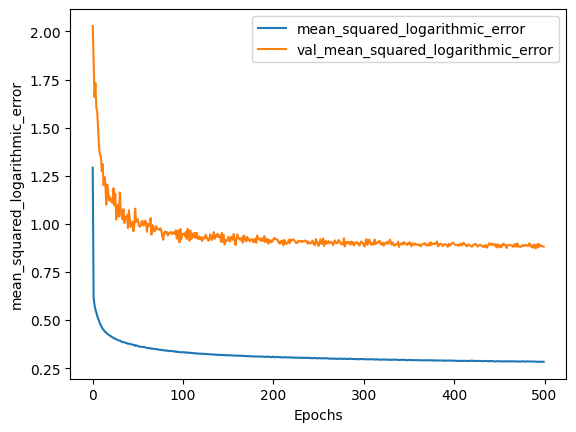

In [9]:
#plotting loss function
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [10]:
#predicting num mosquitos and saving it as a df
test_df['NumMosquitos'] = model_nm.predict(clean_predNM.test_df)
test_df.to_csv('testnm_nn.csv', index = False)

3635/3635 [==============================] - 7s 2ms/step


In [88]:
#defining gridparam search for regression models to predict num mosquitos
def gs_paramsnm(pipe, param):
    model = GridSearchCV(
        estimator = pipe,
        param_grid = param,
        scoring = 'neg_root_mean_squared_error',
        cv = 3,
        n_jobs = -1,
        verbose = 2,
    error_score = 'raise')
    model.fit(Xnm_res, ynm_res)
    #y_pred = model.predict(X_test)
    print(f'Best Params: {model.best_params_}')
    return model 

### Random Forest regressor for Num Mosquitos

In [89]:
#setting up pipe line and params for random forest regressor
rfr_pipe = Pipeline([('rfr', RandomForestRegressor())])
rfr_pipe_params = {
    'rfr__max_depth': [None, 3, 5], # Max depth from root note to leaf node
    'rfr__max_samples': [None, 10, 100], # no of samples 
    'rfr__min_samples_leaf': [5, 10, 100,], # min number of samples in node to be cosidered as a leaf node
    'rfr__min_samples_split': [10, 100, 300], # Min no of samples for pure nodes. The lesser the nummber the lesser the depth
    'rfr__n_estimators': [10, 100, 300],# no of trees
}

In [90]:
#feeding random forest regressor into pre-defined funciton
rfr_model = gs_paramsnm(rfr_pipe, rfr_pipe_params)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Params: {'rfr__max_depth': None, 'rfr__max_samples': 10, 'rfr__min_samples_leaf': 5, 'rfr__min_samples_split': 10, 'rfr__n_estimators': 10}


In [92]:
#predicting and saving the dataframe
test_df['NumMosquitos'] = rfr_model.best_estimator_.predict(clean_predNM.test_df)
test_df.to_csv('testnm_rfr.csv', index = False)

### XGBoost regressor for Num Mosquitos

In [134]:
#setting up pipe line and params for XGBoost regressor
xgr_pipe = Pipeline([('xgr', XGBRegressor())])
xgr_pipe_params = {
    'xgr__learning_rate': [0.01, 0.1],#learing rate, shrinks weight at each step
    'xgr__max_depth': [3, 5, 7, 10], #max depth for trees, to control oeverfitting 
    'xgr__min_child_weight': [1, 3, 5], #min sum of weights on all observations required. Prevents over fitting, if values are too hight it might cause underfitting 
    'xgr__subsample': [0.5, 0.7], # fractions of observations to be randomly sample for each tree. Meant to prevent overfitting, if values are hight it might cause underfitting
    'xgr__colsample_bytree': [0.5, 0.7],#subsample ratio of columns when constructing each tree
    'xgr__n_estimators' : [100, 200, 500], #number of trees to fit
    'xgr__objective': ['reg:squarederror'] #loss function to be minimised
}

In [135]:
#feeding XGBoost regressor into pre-defined funciton
xgr_model = gs_paramsnm(xgr_pipe, xgr_pipe_params)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Params: {'xgr__colsample_bytree': 0.5, 'xgr__learning_rate': 0.1, 'xgr__max_depth': 3, 'xgr__min_child_weight': 1, 'xgr__n_estimators': 500, 'xgr__objective': 'reg:squarederror', 'xgr__subsample': 0.7}


In [136]:
#predicting and saving the dataframe
test_df['NumMosquitos'] = xgr_model.best_estimator_.predict(clean_predNM.test_df)
test_df.to_csv('test_xgrnm.csv', index = False)

## <ins>Predicting WNV Present</ins> 

In [162]:
#using predicted wnv numMosquitos to predict wnv present
features = ['Species', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 'StnPressure', 'SeaLevel', 'month']
cleaned = DataCleaner(train_df, features, test_df_nm)
cleaned.clean()
cleaned.clean_test()
cleaned.test_df['PrecipTotal'] = cleaned.test_df['PrecipTotal'].fillna(0)

In [163]:
#upsampling the data
smt = SMOTETomek(random_state=42)

X_res, y_res = smt.fit_resample(cleaned.X_train, cleaned.y_train)

In [140]:
#gridsearch params to feed models
def gs_params(pipe, param):
    model = GridSearchCV(
        estimator = pipe,
        param_grid = param,
        cv = 3,
        n_jobs = -1,
        verbose = 2,
    error_score = 'raise')
    model.fit(X_res, y_res)
    #y_pred = model.predict(X_test)
    print(f'Best Params: {model.best_params_}')
    print(classification_report(y_res, model.best_estimator_.predict(X_res)))
    print(classification_report(cleaned.y_test, model.best_estimator_.predict(cleaned.X_test)))
    RocCurveDisplay.from_estimator(model.best_estimator_, cleaned.X_test,cleaned.y_test)
    plt.plot([0,1],[0,1],label='baseline',linestyle='--')
    return model

### Random Forest Classifier for WnV present

In [141]:
#setting up pipe line and params for Randomforest Classifier
rc_pipe = Pipeline([('rc', RandomForestClassifier())])
rc_pipe_params = {
    'rc__max_depth': [None, 3, 5], # Max depth from root note to leaf node
    'rc__max_samples': [None, 10, 100], # no of samples 
    'rc__min_samples_leaf': [5, 10, 100,], # min number of samples in node to be cosidered as a leaf node
    'rc__min_samples_split': [10, 100, 300], # Min no of samples for pure nodes. The lesser the nummber the lesser the depth
    'rc__n_estimators': [10, 100, 300],# no of trees
}

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Params: {'rc__max_depth': None, 'rc__max_samples': None, 'rc__min_samples_leaf': 5, 'rc__min_samples_split': 10, 'rc__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      7700
           1       0.91      0.96      0.93      7700

    accuracy                           0.93     15400
   macro avg       0.93      0.93      0.93     15400
weighted avg       0.93      0.93      0.93     15400

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1964
           1       0.26      0.66      0.37       119

    accuracy                           0.87      2083
   macro avg       0.62      0.77      0.65      2083
weighted avg       0.94      0.87      0.90      2083



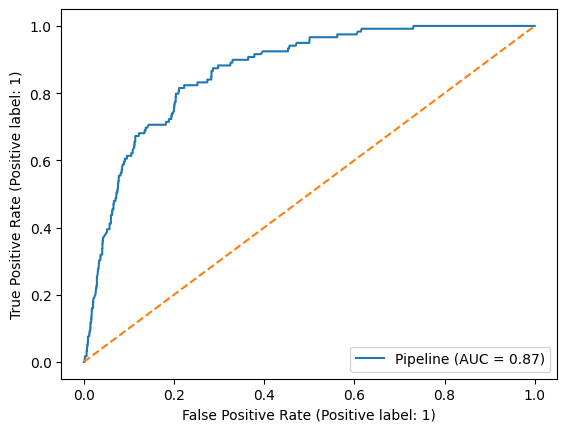

In [142]:
rc_model = gs_params(rc_pipe, rc_pipe_params)

In [143]:
#predicting WnV present from Random Forest Classifier and saving the dataframe for kaggle scoring
pred_rc_xgrnm = pd.DataFrame({'id':test_df_nm['Id'].values , 'WnvPresent': rc_model.best_estimator_.predict(cleaned.test_df)})
pred_rc_xgrnm.to_csv('randforest_xgrnm.csv', index = False)

# Support Vector Classifier

In [144]:
#setting up pipe line and params for Support Vector Classifier
svc_pipe = Pipeline([('svc', SVC())])
svc_pipe_params = {
    'svc__C': [0.1,1, 10, 100],#regularisation
    'svc__gamma': ['scale', 'auto'],#kernel coefficient 
    'svc__kernel': ['linear','rbf','poly', 'sigmoid'] # kerenel algorithm
}

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.93      0.86      0.90      7700
           1       0.87      0.94      0.91      7700

    accuracy                           0.90     15400
   macro avg       0.90      0.90      0.90     15400
weighted avg       0.90      0.90      0.90     15400

              precision    recall  f1-score   support

           0       0.98      0.86      0.91      1964
           1       0.23      0.69      0.34       119

    accuracy                           0.85      2083
   macro avg       0.60      0.77      0.63      2083
weighted avg       0.94      0.85      0.88      2083



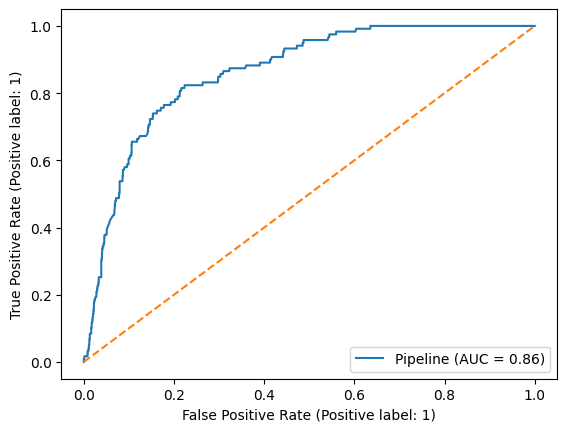

In [145]:
#feeding Support  classifier into pre-defined funciton
svc_model = gs_params(svc_pipe, svc_pipe_params)

In [146]:
#predicting WnV present from Random Forest Classifier and saving the dataframe for kaggle scoring
pred_svc_xgrnm = pd.DataFrame({'id':test_df['Id'].values , 'WnvPresent': svc_model.best_estimator_.predict(cleaned.test_df)})
pred_svc_xgrnm.to_csv('svc_xgrnm.csv', index = False)

# Logistic Regression

In [147]:
#setting up pipe line and params for logistic regression
                 ('lr', LogisticRegression(solver = 'saga'))
                ])

lr_pipe_params = {
    'lr__C': [0.01, 0.1, 1.0, 10, 100],#regularisation
    'lr__penalty': ['elasticnet', 'l1', 'l2', None], #penalty type for regularisation
    'lr__l1_ratio': [0.25, 0.5, 0.75], #specifing ratio for elastic net
}

Fitting 3 folds for each of 60 candidates, totalling 180 fits


C:\Users\user\anaconda3\envs\DA_project_4\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Params: {'lr__C': 100, 'lr__l1_ratio': 0.25, 'lr__penalty': 'elasticnet'}
              precision    recall  f1-score   support

           0       0.83      0.74      0.79      7700
           1       0.77      0.85      0.81      7700

    accuracy                           0.80     15400
   macro avg       0.80      0.80      0.80     15400
weighted avg       0.80      0.80      0.80     15400

              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1964
           1       0.16      0.80      0.26       119

    accuracy                           0.75      2083
   macro avg       0.57      0.77      0.56      2083
weighted avg       0.94      0.75      0.81      2083



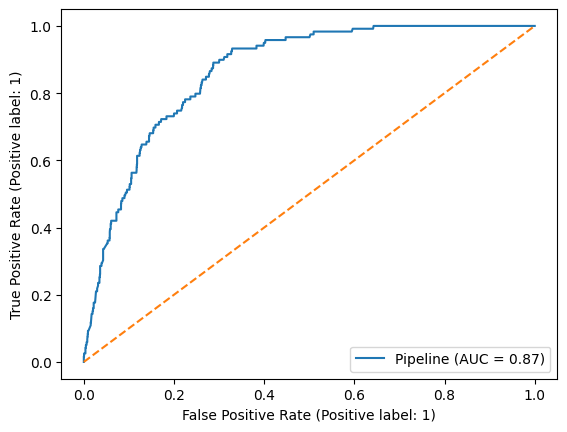

In [148]:
#feeding logistic regression into pre-defined funciton
lr_model = gs_params(lr_pipe, lr_pipe_params)

In [149]:
#predicting WnV present from logistic regression and saving the dataframe for kaggle scoring
pred_lr_xgrnm = pd.DataFrame({'id':test_df['Id'].values, 'WnvPresent': lr_model.best_estimator_.predict(cleaned.test_df)})
pred_lr_xgrnm.to_csv('lr_xgrnm.csv', index = False)

# XGboost Classifier

In [153]:
#setting up pipe line and params for XGbosst Classifier
xgc_pipe = Pipeline([('xgc', XGBClassifier())])
xgc_pipe_params = {
    'xgc__n_estimators': [100, 200, 500],# number of trees to fit
    'xgc__learning_rate': [0.01,0.05,0.1], #learing rate, shrinks weight at each step
    'xgc__booster': ['gbtree', 'gblinear'],  #type of model to run at each iteration
    'xgc__gamma': [0, 0.5, 1],# minimum lost reduction to make split, the larger the gamma the more conservative
    'xgc__reg_alpha': [0, 0.5, 1], #L1 regularisation, the larger the more conservative
    'xgc__reg_lambda': [0.5, 1, 5], #l2 regularisation, the larger the more conservative
}

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Params: {'xgc__booster': 'gbtree', 'xgc__gamma': 0, 'xgc__learning_rate': 0.1, 'xgc__n_estimators': 500, 'xgc__reg_alpha': 1, 'xgc__reg_lambda': 1}
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7700
           1       0.95      0.95      0.95      7700

    accuracy                           0.95     15400
   macro avg       0.95      0.95      0.95     15400
weighted avg       0.95      0.95      0.95     15400

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1964
           1       0.28      0.56      0.38       119

    accuracy                           0.89      2083
   macro avg       0.63      0.74      0.66      2083
weighted avg       0.93      0.89      0.91      2083



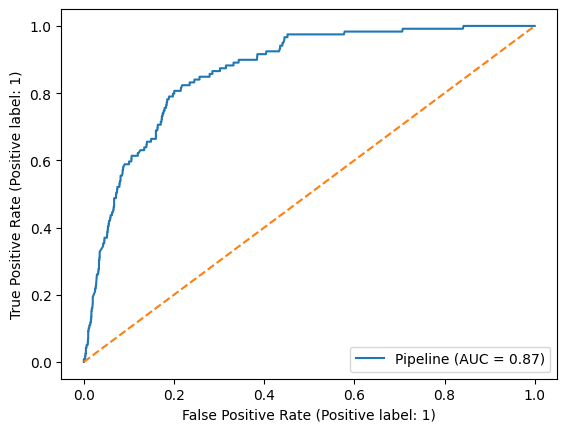

In [154]:
#feeding XGbosst classifier into pre-defined funciton
xgc_model = gs_params(xgc_pipe, xgc_pipe_params)

In [155]:
#predicting WnV present from XGboost Classifier and saving the dataframe for kaggle scoring
pred_xgc_xgrnm = pd.DataFrame({'id':test_df['Id'].values, 'WnvPresent': xgc_model.best_estimator_.predict(cleaned.test_df)})
pred_xgc_xgrnm.to_csv('xgc_xgrnm.csv', index = False)
#public score

# Neural Netowrk 

In [164]:
#Building Neural Nerwork to predict WnV presence
n_input = cleaned.X_train.shape[1]
model_wn = Sequential()
model_wn.add(Dense(n_input, activation='relu', kernel_regularizer=l2(0.003)))
model_wn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_wn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_wn.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))


model_wn.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00008), metrics=[AUC()]) 

es = EarlyStopping(patience=40)

history = model_wn.fit(
    X_res,
    y_res,
    validation_data=(cleaned.X_test, cleaned.y_test),
    epochs=1000,
    batch_size=1000,
    verbose=2,
    callbacks = [es]
)

train_auc = history.history['auc']
test_auc = history.history['val_auc']

plt.figure(figsize=(12, 8))
plt.plot(train_auc, label='Training AUC', color='navy')
plt.plot(test_auc, label='Testing AUC', color='skyblue')
plt.legend();

Epoch 1/1000
16/16 - 1s - loss: 1.0197 - auc_5: 0.6426 - val_loss: 1.0255 - val_auc_5: 0.6842 - 1s/epoch - 90ms/step
Epoch 2/1000
16/16 - 0s - loss: 0.9993 - auc_5: 0.7312 - val_loss: 0.9992 - val_auc_5: 0.7369 - 134ms/epoch - 8ms/step
Epoch 3/1000
16/16 - 0s - loss: 0.9807 - auc_5: 0.7622 - val_loss: 0.9761 - val_auc_5: 0.7565 - 171ms/epoch - 11ms/step
Epoch 4/1000
16/16 - 0s - loss: 0.9633 - auc_5: 0.7725 - val_loss: 0.9600 - val_auc_5: 0.7689 - 167ms/epoch - 10ms/step
Epoch 5/1000
16/16 - 0s - loss: 0.9465 - auc_5: 0.7815 - val_loss: 0.9437 - val_auc_5: 0.7792 - 164ms/epoch - 10ms/step
Epoch 6/1000
16/16 - 0s - loss: 0.9302 - auc_5: 0.7885 - val_loss: 0.9276 - val_auc_5: 0.7889 - 157ms/epoch - 10ms/step
Epoch 7/1000
16/16 - 0s - loss: 0.9140 - auc_5: 0.7957 - val_loss: 0.9103 - val_auc_5: 0.7957 - 151ms/epoch - 9ms/step
Epoch 8/1000
16/16 - 0s - loss: 0.8983 - auc_5: 0.8023 - val_loss: 0.9018 - val_auc_5: 0.8019 - 157ms/epoch - 10ms/step
Epoch 9/1000
16/16 - 0s - loss: 0.8832 - auc_

KeyError: 'auc'

In [165]:
#print ting ROC score
print(roc_auc_score(cleaned.y_test, model_wn.predict(cleaned.X_test)))

66/66 [==============================] - 0s 1ms/step
0.8689670369165996


In [166]:
#reshaping the predictions and setting a threshold to convert outputs to 0 and 1 only 
pred_raw = model.predict(cleaned.test_df).reshape(-1,)
pred_wnv_nn = (pred >= 0.5).astype(int)

3635/3635 [==============================] - 7s 2ms/step


In [160]:
# saving neural netowork predictions for kaggle scoring
pred_nnrf_nmwnv = pd.DataFrame({'id':test_df_nm['Id'].values , 'WnvPresent': pred_wnv_nn})
pred_nnrf_nmwnv.to_csv('neuralnetxgr_numMoswnv.csv', index = False)

# Summary of Model Results

| Model for NumMoSquitos     | WnV Model                 | AUC (Train Data Set) | Kaggle Score | Best Params WNV Model                                                                                                                         |
|----------------------------|---------------------------|----------------------|--------------|-----------------------------------------------------------------------------------------------------------------------------------------------|
| Neural Net Regression      | Neural Net Classifier     | 0.87                 | 0.54         | N.A                                                                                                                                           |
| Neural Net Regression      | RandomForestClassifier    | 0.86                 | 0.56         | rc__max_depth': None, 'rc__max_samples': None, 'rc__min_samples_leaf': 5, 'rc__min_samples_split': 10, 'rc__n_estimators': 100                |
| Neural Net Regression      | Support Vector Classifier | 0.86                 | 0.51         | 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'                                                                                    |
| Neural Net Regression      | Logistic Regression       | 0.87                 | 0.54         | 'lr__C': 100, 'lr__l1_ratio': 0.75, 'lr__penalty': 'l2'                                                                                       |
| Neural Net Regression      | XGB Classifier            | 0.87                 | 0.57         | 'xgc__booster': 'gbtree', 'xgc__gamma': 0, 'xgc__learning_rate': 0.1, 'xgc__n_estimators': 500, 'xgc__reg_alpha': 1, 'xgc__reg_lambda': 1     |
| RandomForestRegression     | Neural Net Classifier     | 0.87                 | 0.53         | N.A                                                                                                                                           |
| RandomForestRegression     | RandomForestClassifier    | 0.87                 | 0.56         | 'rc__max_depth': None, 'rc__max_samples': None, 'rc__min_samples_leaf': 5, 'rc__min_samples_split': 10, 'rc__n_estimators': 100               |
| RandomForestRegression     | Support Vector Classifier | 0.86                 | 0.53         | 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'                                                                                    |
| RandomForestRegression     | Logistic Regression       | 0.87                 | 0.55         | 'lr__C': 100, 'lr__l1_ratio': 0.25, 'lr__penalty': 'l2'                                                                                       |
| **RandomForestRegression** | **XGB Classifier**        | **0.87**             | **0.59**     | **'xgc__booster': 'gbtree', 'xgc__gamma': 0, 'xgc__learning_rate': 0.1, 'xgc__n_estimators': 500, 'xgc__reg_alpha': 1, 'xgc__reg_lambda': 1** |
| XGB Regression             | Neural Net Classifier     | 0.87                 | 0.53         | N.A                                                                                                                                           |
| XGB Regression             | RandomForestClassifier    | 0.87                 | 0.56         | 'rc__max_depth': None, 'rc__max_samples': None, 'rc__min_samples_leaf': 5, 'rc__min_samples_split': 10, 'rc__n_estimators': 300               |
| XGB Regression             | Support Vector Classifier | 0.86                 | 0.52         | 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'                                                                                    |
| XGB Regression             | Logistic Regression       | 0.87                 | 0.54         | 'lr__C': 100, 'lr__l1_ratio': 0.25, 'lr__penalty': 'elasticnet'                                                                               |
| XGB Regression             | XGB Classifier            | 0.87                 | 0.52         | 'xgc__booster': 'gbtree', 'xgc__gamma': 0, 'xgc__learning_rate': 0.1, 'xgc__n_estimators': 500, 'xgc__reg_alpha': 1, 'xgc__reg_lambda': 1     |

### Plotting Num Mosquitos distributions from different models and Train Df

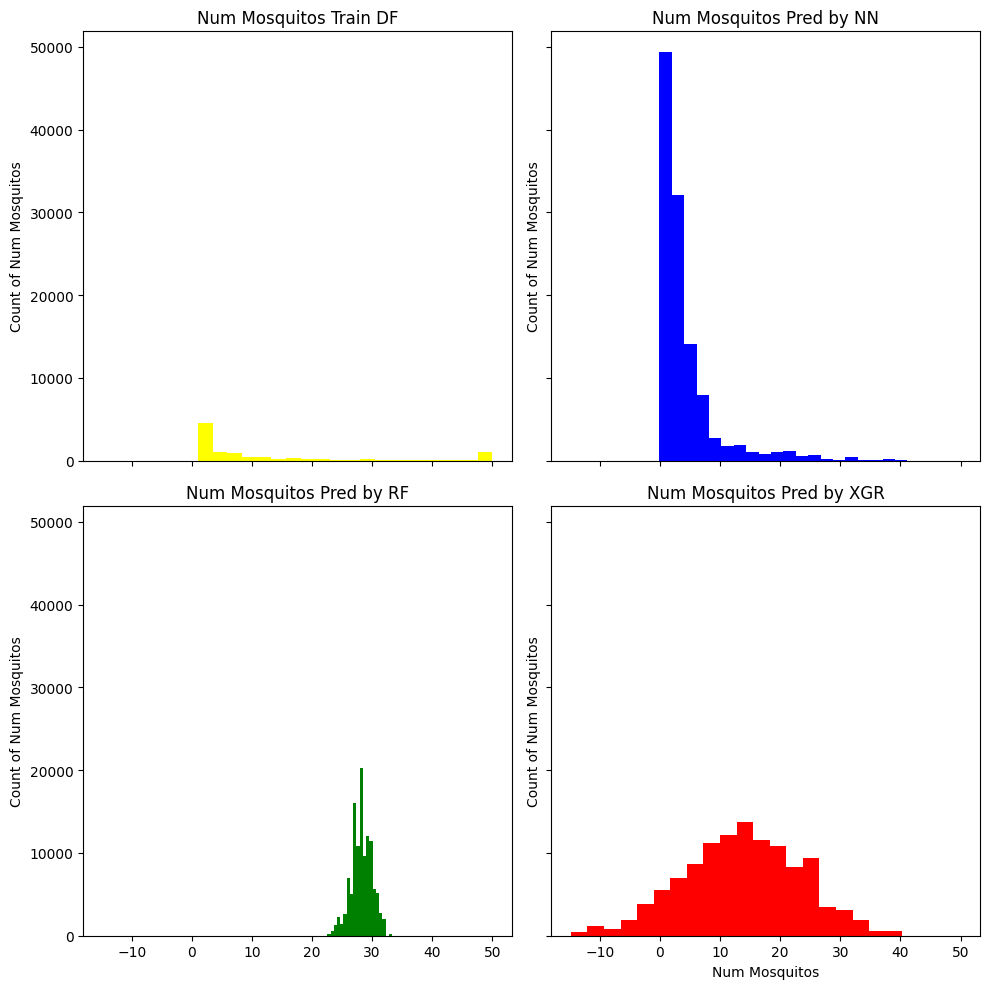

In [201]:
train_df = pd.read_csv("./train_sprayed_month_engineered.csv")
test_df_nm = pd.read_csv("./testnm_nn.csv")
test_df_nm_rf = pd.read_csv("./testnm_rfr.csv")
test_df_nm_xgc = pd.read_csv("./test_xgrnm.csv")

# Generate some example data (replace with your own data)
#import numpy as np
nn_mospred = test_df_nm['NumMosquitos'].values  # Data for X-axis
rf_mospred = test_df_nm_rf['NumMosquitos'].values  # Data for Y-axis
xgr_mospred = test_df_nm_xgc['NumMosquitos'].values  # Data for Z-axis

# Create three separate histograms
fig, axes  = plt.subplots(2,2, sharex=True, sharey = True, figsize = (10,10))

axes[0,0].hist(train_df['NumMosquitos'].values, bins=20, color='yellow')
axes[0,0].set_ylabel('Count of Num Mosquitos')
axes[0,0].set_title('Num Mosquitos Train DF') 

axes[0,1].hist(nn_mospred, bins=20, color='blue')
axes[0,1].set_ylabel('Count of Num Mosquitos')
axes[0,1].set_title('Num Mosquitos Pred by NN') 

axes[1,0].hist(rf_mospred , bins=20, color='green')
axes[1,0].set_ylabel('Count of Num Mosquitos')
axes[1,0].set_title('Num Mosquitos Pred by RF') 


axes[1,1].hist(xgr_mospred, bins=20, color='red')
axes[1,1].set_ylabel('Count of Num Mosquitos')
axes[1,1].set_title('Num Mosquitos Pred by XGR') 
axes[1,1].set_xlabel('Num Mosquitos') 

# Adjust spacing between subplots
plt.tight_layout()

# Combine the three subplots into a single figure
plt.show()

# Observations, Insights and Conclusion 

*** 


__<ins>Observations </ins>__ 

``` 

1. The selection of the rbf kernel for the support vector classifier suggests that the target variable does not have a linear relationship with its features. 

2. The XGB classifier emerged as the top model for predicting WNV from 2/3 num mosquitos regression prediction that was performed.

``` 

__<ins>Insights Best Scoring model</ins>__ 

``` 

The best model yielded a result of 0.59 AUC score. This model used random forest regression to predict the num mosquitos and the xgb classifier to predict the presence of WNV. Most of the random forest regressor best prams, such as max sample, min sample leafs, and n estimators, were at the low end. Usually, high figures are fed to the parameters to overcome overfitting. This could be an indication that the random forest regressor could be trying to combat fitting instead. Conversely, the XGB boost classifier's best parameters were on the higher end instead. Both the regularisation parameters, alpha, and lambda, were selected as 1, and the number of estimators was selected as 500, which was the highest option that was provided to the gridsearch CV. Hence, this suggests that the XGB classifier could be combating overfitting. The overfitting can also be observed when the train AUC is compared against the Kaggles test AUC score. All models performed at least 30% poorer when predicting the Kaggle test data set.

``` 

__<ins> Modelling Conclusions</ins>__ 

``` 

Since num mosquitos have a high correlation with the presence of WNV, the distribution of the number of mosquitos predicted by the different models and train data frame was plotted for analysis. We can observe that all 3 models have vast differences in predicting the number of mosquitos. While the neural network model had the closest distribution resemblance to train df, it only emerged as the 2nd top highest score with the XGB classifier. From our EDA we can observe that that there is a time lag for WNV to be detected after the presence of mosquitos, We believe this model could appear as the best model if that time lag was factored into our feature. This could be done as part of future work.

``` 
